In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.1.0
TF-Hub version:  0.8.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  False


In [2]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

#4次元画像表示
def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

#3次元画像表示
def show_n_3d(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

In [3]:
#テンソル化
from PIL import Image
import numpy as np
import tensorflow as tf

def convert_img(file): 
    global h,w
    image = tf.io.read_file(file)
    image = tf.image.decode_jpeg(image, channels=3)

    #4次元化にreshapeするためPIL化
    pilImg_rgb = Image.fromarray(np.uint8(image))
    pilImg_rgb = np.array(pilImg_rgb, dtype='float32')
    h = len(image)
    w = len(image[0])
    a = pilImg_rgb.reshape(1, h, w, 3)

    #画像の数値をrgb用からfloat用にする（255で割って0～1の間にする）
    image = tf.convert_to_tensor(a/255.0)

    #大き目の画像サイズ縮小（元画像の3分の１)
    if h >= 1000 or w >= 1000:
        h = int(h/3)
        w = int(w/3)
        image = tf.image.resize(image, [h, w])
    return image

image = convert_img("bike2-sen.jpg")
style_image = convert_img("dragonball.jpg")

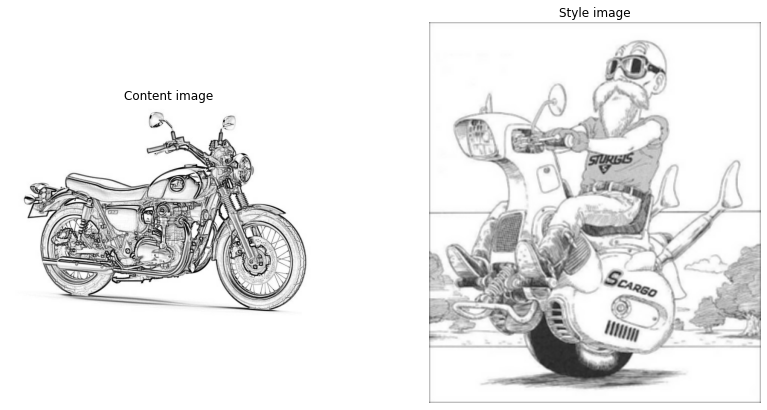

In [4]:
#content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
#style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
#output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
#content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

#gray = cv2.imread('/img1.jpg', cv2.IMREAD_GRAYSCALE)
content_image = image
#style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [5]:
#ローカルにダウンロードして読み込み　modelフォルダの.tar.gzファイルを　tar zxvf 圧縮ファイル　で解凍
from tensorflow import keras
hub_module = keras.models.load_model("model")

# Load TF-Hub module.
#hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
#hub_module = hub.load(hub_handle)

In [6]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

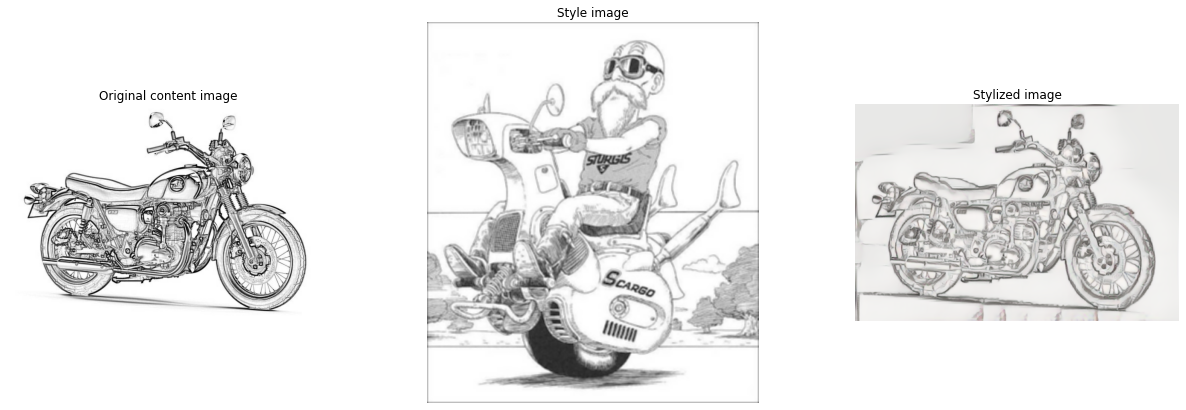

In [7]:
# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])


In [8]:
stylized_image_unit = tf.cast(stylized_image*255.0, tf.uint8)

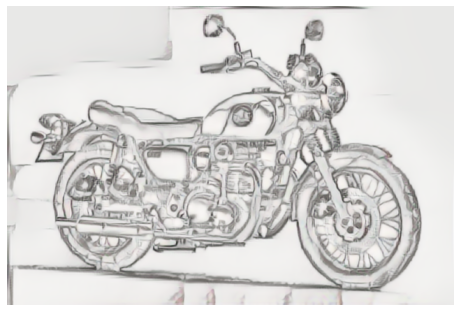

In [9]:
show_n([stylized_image_unit])

In [10]:
#3次元化
stylized_image_unit_3d = tf.reshape(
    stylized_image_unit,
    [len(stylized_image_unit[0]), len(stylized_image_unit[0][1]), 3]
)

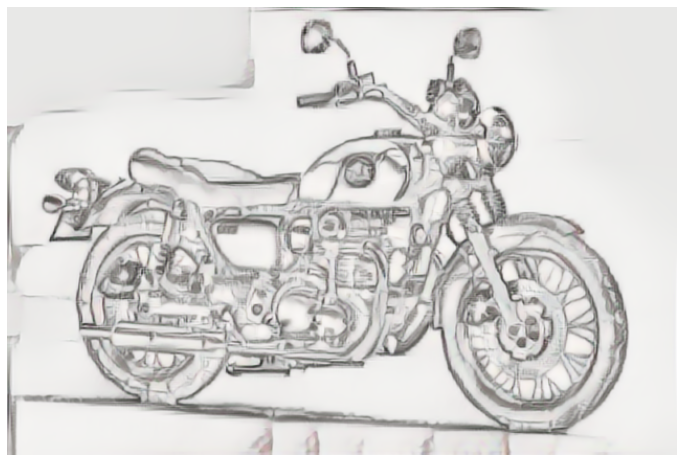

In [11]:
show_n_3d([stylized_image_unit_3d])

In [14]:
stylized_image_unit

<tf.Tensor: shape=(1, 428, 640, 3), dtype=uint8, numpy=
array([[[[232, 232, 231],
         [232, 232, 231],
         [232, 232, 231],
         ...,
         [232, 232, 231],
         [232, 232, 231],
         [232, 232, 231]],

        [[232, 232, 231],
         [232, 232, 231],
         [232, 232, 231],
         ...,
         [232, 232, 231],
         [232, 232, 231],
         [232, 232, 231]],

        [[232, 232, 231],
         [232, 232, 231],
         [232, 232, 231],
         ...,
         [232, 232, 231],
         [232, 232, 231],
         [232, 232, 231]],

        ...,

        [[195, 191, 191],
         [201, 197, 195],
         [202, 197, 198],
         ...,
         [235, 234, 233],
         [235, 234, 233],
         [235, 234, 233]],

        [[196, 192, 192],
         [202, 198, 197],
         [203, 198, 199],
         ...,
         [235, 234, 233],
         [235, 234, 233],
         [235, 234, 233]],

        [[197, 192, 192],
         [202, 198, 197],
         [203, 198

In [17]:
#画像書き出し
import cv2
import imageio
import os
import tkinter.filedialog

#filepath = tkinter.filedialog.askopenfilename(initialdir='./')
#basename = os.path.basename(filepath)
#basename_without_ext = os.path.splitext(os.path.basename(filepath))[0]

#imageio.imwrite("conv/{}_conv.jpg".format(basename_without_ext),stylized_image_unit_3d)
imageio.imwrite("test.jpg", stylized_image_unit_3d)

In [ ]:
os.path.splitext(os.path.basename(filepath))

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf


#image = tf.io.read_file("img1.jpg")
#image = tf.image.decode_jpeg(image, channels=3)

#4次元化にreshapeするためPIL化
#pilImg_rgb = Image.fromarray(np.uint8(image))
#pilImg_rgb = np.array(pilImg_rgb, dtype='float32')

#img = tf.image.encode_jpeg(stylized_image_unit_3d, format='rgb')
#img2 = tf.image.decode_jpeg(img, channels=3)

#pilImg_rgb = Image.fromarray(np.uint8(stylized_image_unit_3d))
stylized_img = Image.open("conv/{}_conv.jpg".format(basename_without_ext))
#self.stylized_img = ImageTk.PhotoImage(pilImg_rgb)

In [ ]:
stylized_img.format

In [ ]:
print(a)

In [ ]:
### インポート
import tkinter
from PIL import Image,ImageTk
 
### 画像ロード
image = Image.open("conv/{}_conv.jpg".format(basename_without_ext))
 
### サイズ縮小
w_size = int(image.width/4)
h_size = int(image.height/4)
 
### キャンバス作成
canvas = tkinter.Canvas(width=w_size, height=h_size)
 
### PhotoImage変換
tk_image = ImageTk.PhotoImage(image=image.resize((w_size,h_size)))
 
### 画像描画
canvas.create_image(0, 0, anchor="nw", image=tk_image)
 
### キャンバス表示
canvas.pack()
 
### イベントループ
canvas.mainloop()

In [ ]:
image.format